# DPA

In [26]:
#============================================================
# Verson 1.2 19/05/2023
#============================================================

import tensorflow as tf
import sys
sys.path.append('./cs16')
import cs16.prep as prep16
import cs16.plot as plot16
import cs16.build as build16

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from keras.callbacks import EarlyStopping
from keras.layers import (Activation, Attention, Bidirectional, Concatenate, Conv1D, Conv2D, Add, Multiply,
                           Dense, Dropout, Embedding, Flatten, GlobalMaxPooling1D, GlobalMaxPooling2D,MaxPooling2D,
                           Input, Layer, LSTM, MaxPooling2D, Multiply, Permute, AveragePooling2D, UpSampling2D,
                           RepeatVector, Reshape, SpatialDropout1D, TimeDistributed, GlobalAveragePooling2D, BatchNormalization)

from keras.models import Model
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

imagesize = 64

#------------------------------------------------------------
# Dataset Selection
#------------------------------------------------------------

data_type = input("Enter '1. single' for single dataset or '2. multi' for multiple dataset: ")

if data_type == '1':
    file_path = 'single.txt'
    folder_path = 'C:/Users/Jeffan/Downloads/MVSA-Single/MVSA_Single/data/'
elif data_type == '2':
    file_path = 'multi.txt'
    folder_path = 'C:/Users/Jeffan/Downloads/MVSA-multiple/MVSA/data/'
else:
    print("Invalid input. Please enter either 'single' or 'multi'.")
    exit()

df = pd.read_csv(file_path, index_col=None, encoding='ISO-8859-1')


# Text Preprocess

In [13]:
# %pip install demoji

In [27]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt
import contractions
import demoji

nltk.download('stopwords')
nltk.download('punkt')

# Define a function to preprocess text
def nlp_text(text, use_emoji = False):
    
    #--------- TEXT -----------
    # Convert text to lowercase
    text = text.lower()
    text = re.sub(r'http\S+', '', text) # Remove URLs 
    text = re.sub(r'RT @\w+: |@\w+', '', text) # Remove @user 
    text = re.sub(r'#\w*', '', text) # Remove Tags
    if use_emoji:
        # inittext = text
        text = demoji.replace_with_desc(text)
        # aftertext = text
        # if inittext != aftertext:
        #     print("emoji detected")
        #     print(inittext)
        #     print(aftertext)
    text = contractions.fix(text) # expand contractions
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation

    words = word_tokenize(text) # Tokenize text into words
    
    #--------- WORD -----------
    # stop_words = set(stopwords.words('english'))
    # words = [word for word in words if word not in stop_words]
    
    # --------- Stemmer -----------
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
   
    text = ' '.join(words) # Join words back into a single string
    
    return text

# Apply the preprocess_text function to the 'tweet' column of the dataframe
df['tweet'] = df['tweet'].apply(nlp_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jeffan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jeffan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Train/Val/Test

In [28]:

#---------------Text--------------------
X_text, y_text = prep16.preprocess_text(df)
X_train_text, X_val_text, X_test_text, \
y_train_text, y_val_text, y_test_text = prep16.split_data(X_text, y_text, random_state=42)

#---------------Image--------------------
image_data_s, image_label_s = prep16.preprocess_images(df, folder_path, imagesize)
y_s = to_categorical(image_label_s, num_classes=3)

X_train_image, X_val_image, X_test_image, \
y_train_image, y_val_image, y_test_image= prep16.split_data(image_data_s, y_s, random_state=42)


#---------------combined--------------------
X_polar, y_polar = prep16.preprocess_text(df,label = 'polarity')
X_train_polar, X_val_polar, X_test_polar, \
y_train_polar, y_val_polar, y_test_polar = prep16.split_data(X_polar, y_polar, random_state=42)


y_train = to_categorical(y_train_polar, num_classes=3)
y_val =to_categorical(y_val_polar, num_classes=3)
y_test =to_categorical(y_test_polar, num_classes=3)
print(f"Processed Dataset:{file_path}")

Processed Dataset:single.txt


# Polarity Distribution

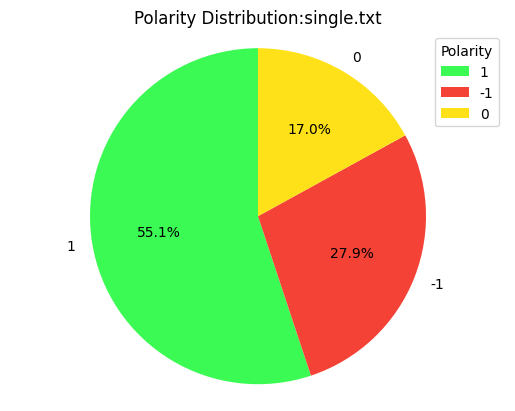

In [29]:
#distribution of polarity
polarity_counts =df['polarity'].value_counts(normalize=True)

# assign colors for each category
colors = ['#3cfa54', '#f44336', '#ffe119']

# Create a pie chart of the polarity distribution
plt.pie(polarity_counts.values, labels=polarity_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title(f'Polarity Distribution:{file_path}')
plt.legend(title='Polarity', loc='best')
plt.show()

# TEXT

In [30]:
#============================================================
# TEXT Classification
# Pipeline 1: BiLSTM
# Pipeline 2: BiLSTM
#============================================================
textclassifier ='BiLSTM + ATT' 
from keras import regularizers
from keras.layers import Bidirectional, LSTM, Concatenate, Reshape

#---------------ContentAttention--------------------
# code adopted and modified from : 
# https://machinelearningmastery.com/adding-a-custom-attention-layer-to-recurrent-neural-network-in-keras/
# https://www.kaggle.com/code/haithemhermessi/attention-mechanism-keras-as-simple-as-possible


class ContentAttention(Layer):
    def __init__(self, **kwargs):
        super(ContentAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(ContentAttention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)    
    
text_input = Input(shape=(X_train_text.shape[1],), dtype='int32', name='text_input')

embedding_layer = Embedding(input_dim=10000, output_dim=100, 
                            input_length=X_train_text.shape[1])(text_input)

#--------- pipeline1 -----------
lstm1 = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
lstm1 = Dropout(0.25)(lstm1) 
att_layer1 = ContentAttention()(lstm1)
sent_representation1 = att_layer1

#--------- pipeline2 -----------
lstm2 = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
lstm2 = Dropout(0.25)(lstm2) 
att_layer2 = ContentAttention()(lstm2)
sent_representation2 = att_layer2

#--------- Concatenate -----------
merged_layer = Concatenate()([sent_representation1, sent_representation2]) 
merged = Dense(128, activation='tanh')(merged_layer)

reshaped = Reshape((1, 128))(merged)  
t = Bidirectional(LSTM(256))(reshaped)
text_output = Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(t)

print(textclassifier)

BiLSTM + ATT


In [31]:
from tensorflow.keras.metrics import Precision, Recall, AUC

precision = Precision()
recall = Recall()

def F1Score(y_true, y_pred): 
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    return 2*((precision_value*recall_value)/(precision_value+recall_value+1e-5))


In [32]:
from keras.layers import Embedding, BatchNormalization
from keras.layers import Bidirectional, LSTM, Input, Dense, Dropout, Concatenate, MultiHeadAttention, GlobalAveragePooling1D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

def transformer_pipeline(input_layer, num_heads, key_dim, dropout_rate):
    transformer_block = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
    transformed = transformer_block(input_layer, input_layer)
    dropout = Dropout(dropout_rate)(transformed)
    return dropout

def lstm_pipeline(input_layer, units, dropout_rate):
    lstm = Bidirectional(LSTM(units, return_sequences=True))(input_layer)
    lstm = Dropout(dropout_rate)(lstm)
    att_layer = ContentAttention()(lstm)
    return att_layer

# Create callbacks
earlystop_callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

# Define input
text_input = Input(shape=(X_train_text.shape[1],), dtype='int32', name='text_input')
embedding_layer = Embedding(input_dim=10000, output_dim=100, input_length=X_train_text.shape[1])(text_input)

# Create transformer pipelines
dropout1 = transformer_pipeline(embedding_layer, num_heads=2, key_dim=2, dropout_rate=0.5)
dropout2 = transformer_pipeline(embedding_layer, num_heads=2, key_dim=2, dropout_rate=0.5)
# dropout3 = transformer_pipeline(embedding_layer, num_heads=2, key_dim=2, dropout_rate=0.5)

# Create LSTM pipelines
sent_representation1 = lstm_pipeline(embedding_layer, units=256, dropout_rate=0.25)
sent_representation2 = lstm_pipeline(embedding_layer, units=128, dropout_rate=0.25)
sent_representation3 = lstm_pipeline(embedding_layer, units=64, dropout_rate=0.25)

# Concatenate and pool
merged_transformer_layer = Concatenate()([dropout1, dropout2])
pooled = GlobalAveragePooling1D()(merged_transformer_layer)
merged_lstm_layer = Concatenate()([sent_representation1, sent_representation2, sent_representation3]) 

merged_layer = Concatenate()([pooled, merged_lstm_layer])
merged_layer = BatchNormalization()(merged_layer)
merged = Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.01))(merged_layer)

# Output
text_output = Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(merged)

model = Model(inputs=text_input, outputs=text_output)

# Compile the model
optimizer = Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', F1Score])

# Train the model
history = model.fit(X_train_text, y_train, validation_data=(X_val_text, y_val),
                    epochs=10, batch_size=32, callbacks=[earlystop_callback, lr_scheduler])

# Evaluate the model
test_loss, test_acc, test_f1 = model.evaluate(X_test_text, y_test)
print('Test accuracy:', test_acc)
print('Test F1 Score:', test_f1)


Epoch 1/10
122/122 [==============================] - 269s 2s/step - loss: 1.4727 - accuracy: 0.5589 - F1Score: 0.3858 - val_loss: 1.0463 - val_accuracy: 0.5462 - val_F1Score: 0.4821 - lr: 0.0010
Epoch 2/10
 90/122 [=====================>........] - ETA: 1:08 - loss: 0.7132 - accuracy: 0.7188 - F1Score: 0.5395

KeyboardInterrupt: 

In [ ]:
from keras.layers import Embedding, BatchNormalization
from keras.layers import Bidirectional, LSTM, Input, Dense, Dropout, Concatenate, MultiHeadAttention, GlobalAveragePooling1D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

def transformer_pipeline(input_layer, num_heads, key_dim, dropout_rate):
    transformer_block = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
    transformed = transformer_block(input_layer, input_layer)
    dropout = Dropout(dropout_rate)(transformed)
    return dropout

def lstm_pipeline(input_layer, units, dropout_rate):
    lstm = Bidirectional(LSTM(units, return_sequences=True))(input_layer)
    lstm = Dropout(dropout_rate)(lstm)
    att_layer = ContentAttention()(lstm)
    return att_layer

# Create callbacks
earlystop_callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

# Define input
text_input = Input(shape=(X_train_text.shape[1],), dtype='int32', name='text_input')
embedding_layer = Embedding(input_dim=10000, output_dim=100, input_length=X_train_text.shape[1])(text_input)

# Create transformer pipelines
dropout1 = transformer_pipeline(embedding_layer, num_heads=2, key_dim=2, dropout_rate=0.5)
# dropout2 = transformer_pipeline(embedding_layer, num_heads=2, key_dim=2, dropout_rate=0.5)
# dropout3 = transformer_pipeline(embedding_layer, num_heads=2, key_dim=2, dropout_rate=0.5)

# Create LSTM pipelines
# sent_representation1 = lstm_pipeline(embedding_layer, units=256, dropout_rate=0.25)
sent_representation2 = lstm_pipeline(embedding_layer, units=128, dropout_rate=0.25)
sent_representation3 = lstm_pipeline(embedding_layer, units=64, dropout_rate=0.25)

# Concatenate and pool
merged_transformer_layer = Concatenate()([dropout1])
pooled = GlobalAveragePooling1D()(merged_transformer_layer)
merged_lstm_layer = Concatenate()([sent_representation2, sent_representation3]) 

merged_layer = Concatenate()([pooled, merged_lstm_layer])
merged_layer = BatchNormalization()(merged_layer)
merged = Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.01))(merged_layer)

# Output
text_output = Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(merged)

model = Model(inputs=text_input, outputs=text_output)

# Compile the model
optimizer = Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', F1Score])

# Train the model
history = model.fit(X_train_text, y_train, validation_data=(X_val_text, y_val),
                    epochs=10, batch_size=32, callbacks=[earlystop_callback, lr_scheduler])

# Evaluate the model
test_loss, test_acc, test_f1 = model.evaluate(X_test_text, y_test)
print('Test accuracy:', test_acc)
print('Test F1 Score:', test_f1)


Epoch 1/10
487/487 [==============================] - 304s 614ms/step - loss: 0.8879 - accuracy: 0.7456 - F1Score: 0.7660 - val_loss: 0.7664 - val_accuracy: 0.7704 - val_F1Score: 0.7641 - lr: 0.0010
Epoch 2/10
487/487 [==============================] - 320s 656ms/step - loss: 0.6433 - accuracy: 0.7658 - F1Score: 0.7639 - val_loss: 1.1389 - val_accuracy: 0.7725 - val_F1Score: 0.7640 - lr: 0.0010
Epoch 3/10
487/487 [==============================] - 296s 608ms/step - loss: 0.5868 - accuracy: 0.7812 - F1Score: 0.7656 - val_loss: 0.6850 - val_accuracy: 0.7684 - val_F1Score: 0.7661 - lr: 0.0010
Epoch 4/10
487/487 [==============================] - 285s 586ms/step - loss: 0.5447 - accuracy: 0.7936 - F1Score: 0.7677 - val_loss: 0.9543 - val_accuracy: 0.7704 - val_F1Score: 0.7689 - lr: 0.0010
Epoch 5/10
487/487 [==============================] - 289s 594ms/step - loss: 0.5064 - accuracy: 0.8068 - F1Score: 0.7707 - val_loss: 0.8231 - val_accuracy: 0.7673 - val_F1Score: 0.7722 - lr: 0.0010
Epoch

# IMAGE 

In [6]:
#============================================================
# Image Classification
# Pipeline 1: Multilayer CNN
# Pipeline 2: VGG + ATT
#============================================================
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import regularizers

imageclassifier = 'Multi-CNN + VGG & Spatial ATT'

#-----------------Multilayer CNN---------------------
# dropout can be on and off when necessary

image_input = Input(shape=(64, 64, 3), name='image_input')
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#pool1 = Dropout(0.25)(pool1)
pool1 = BatchNormalization()(pool1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#pool2 = Dropout(0.25)(pool2)
pool2 = BatchNormalization()(pool2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#pool3 = Dropout(0.25)(pool3)
pool3 = BatchNormalization()(pool3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
#pool4 = Dropout(0.25)(pool4)
pool4 = BatchNormalization()(pool4)
flatten = Flatten()(pool4)

#-----------------VGG---------------------
# Load pre-trained VGG16 model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(imagesize, imagesize, 3))

# Freeze
for layer in vgg16_base.layers:
    layer.trainable = False

vgg16_features = vgg16_base(image_input)

# -----------------Add spatial attentions---------------------
# 1 filter, sigmoid to set 0 or 1 for weights
attention = Conv2D(1, (1, 1), activation='sigmoid')(vgg16_features) 
attended_features = Multiply()([vgg16_features, attention])

# Flatten
attended_flatten = Flatten()(attended_features)

#------------- Concatenate -----------------------
merged_features = Concatenate()([flatten, attended_flatten])

# Apply the rest of the model layers
merged = Dense(128, activation='relu')(merged_features)
merged = Dropout(0.25)(merged)
image_output = Dense(3, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(merged)

print(imageclassifier)

Multi-CNN + VGG & Spatial ATT


# EARLY Fusion : Text & Image

In [7]:
from keras.optimizers import Adam, Adagrad, RMSprop
from keras import backend as K
from keras import metrics

concatenated = Concatenate()([text_output, image_output])
concatenated = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(concatenated)
reshaped = Reshape((1, 1, concatenated.shape[1]))(concatenated)

#>> downsampling test
pooled = GlobalMaxPooling2D()(reshaped) 
#pooled = GlobalAveragePooling2D()(reshaped)

# Final output layers
output = Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(pooled)

model = Model(inputs=[text_input, image_input], outputs=output)
print(file_path)

# Compile the model
optimizer = Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit([X_train_text, X_train_image], y_train, 
                    validation_data=([X_val_text, X_val_image], y_val),
                    epochs=10, 
                    batch_size=32)

# Evaluate the model
test_loss, test_acc = model.evaluate([X_test_text, X_test_image], y_test)
print('Test accuracy:', test_acc)


single.txt
Epoch 1/10
122/122 [==============================] - 92s 690ms/step - loss: 1.1783 - accuracy: 0.5350 - val_loss: 1.1024 - val_accuracy: 0.5462
Epoch 2/10
122/122 [==============================] - 90s 735ms/step - loss: 1.0613 - accuracy: 0.5492 - val_loss: 1.0471 - val_accuracy: 0.5462
Epoch 3/10
122/122 [==============================] - 87s 716ms/step - loss: 1.0265 - accuracy: 0.5492 - val_loss: 1.0331 - val_accuracy: 0.5462
Epoch 4/10
122/122 [==============================] - 88s 718ms/step - loss: 1.0117 - accuracy: 0.5492 - val_loss: 1.0105 - val_accuracy: 0.5462
Epoch 5/10
122/122 [==============================] - 89s 729ms/step - loss: 1.0020 - accuracy: 0.5492 - val_loss: 1.0212 - val_accuracy: 0.5462
Epoch 6/10
122/122 [==============================] - 78s 641ms/step - loss: 1.0008 - accuracy: 0.5492 - val_loss: 1.0161 - val_accuracy: 0.5462
Epoch 7/10
122/122 [==============================] - 79s 648ms/step - loss: 0.9920 - accuracy: 0.5492 - val_loss: 1.01

# Classification Report

In [16]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on test data
y_pred = model.predict([X_test_text, X_test_image])

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_true_classes, y_pred_classes, digits = 4)
print(f"image:{imageclassifier}, Text:{textclassifier}")
# Print the report
print('Classification Report:\n', report)


16/16 [==============================] - 6s 302ms/step
image:Multi-CNN + VGG & Spatial ATT, Text:BiLSTM + Content att
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        77
           1     0.5708    1.0000    0.7268       278
           2     0.0000    0.0000    0.0000       132

    accuracy                         0.5708       487
   macro avg     0.1903    0.3333    0.2423       487
weighted avg     0.3259    0.5708    0.4149       487



C:\Users\ausco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ausco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ausco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LATE FUSION: Text & Image

In [12]:
#----------------image----------------
image_feature_extractor = Model(inputs=image_input, outputs=image_output)
val_image_features = image_feature_extractor.predict(X_val_image)
test_image_features = image_feature_extractor.predict(X_test_image)

#--------------text----------------
text_feature_extractor = Model(inputs=text_input, outputs=text_output)
val_text_features = text_feature_extractor.predict(X_val_text)
test_text_features = text_feature_extractor.predict(X_test_text)

#---------------combine----------------
val_features = np.concatenate([val_image_features, val_text_features], axis=1)
test_features = np.concatenate([test_image_features, test_text_features], axis=1)

y_val_labels = y_val_polar
y_test_labels = y_test_polar

16/16 [==============================] - 1s 39ms/step


## XGB

In [13]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Encode the target variable XGB uses 0,1,2
label_encoder = LabelEncoder()
y_val_labels_encoded = label_encoder.fit_transform(y_val_labels)
y_test_labels_encoded = label_encoder.transform(y_test_labels)

# ***** please modify n_estimators, max_depth to get different results *****
xgb_model = xgb.XGBClassifier(n_estimators=80, max_depth=6) #reg_lambda reg_alpha

xgb_model.fit(val_features, y_val_labels_encoded)

# Evaluate
xgb_score = xgb_model.score(test_features, y_test_labels_encoded)
print("Late Fusion Test Accuracy: {:.2f}%".format(xgb_score * 100))

y_pred = xgb_model.predict(test_features)

print(classification_report(y_test_labels_encoded, y_pred, digits=4))

Late Fusion Test Accuracy: 52.36%
              precision    recall  f1-score   support

           0     0.3118    0.2197    0.2578       132
           1     0.2083    0.1299    0.1600        77
           2     0.6243    0.7770    0.6923       278

    accuracy                         0.5236       487
   macro avg     0.3815    0.3755    0.3700       487
weighted avg     0.4738    0.5236    0.4904       487



## Random Forest

In [14]:
#--------------logistic Regression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
# ***** please modify n_estimators, max_depth to get different results *****
rf = RandomForestClassifier(n_estimators=140, max_depth=11)

rf.fit(val_features, y_val_labels)
rf_score = rf.score(test_features, y_test_labels)
print("Late Fusion Test Accuracy: {:.2f}%".format(rf_score * 100))
#from sklearn.metrics import classification_report

# Predict labels for test data
y_pred = rf.predict(test_features)

# Print classification report
print(classification_report(y_test_labels, y_pred, digits=4))

Late Fusion Test Accuracy: 52.77%
              precision    recall  f1-score   support

          -1     0.3176    0.2045    0.2488       132
           0     0.1364    0.0390    0.0606        77
           1     0.5974    0.8165    0.6900       278

    accuracy                         0.5277       487
   macro avg     0.3505    0.3534    0.3331       487
weighted avg     0.4487    0.5277    0.4709       487



# MLP

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Create an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(256, 128), 
                    activation='relu', solver='lbfgs', learning_rate = 'invscaling')

# Fit the classifier to the training data
mlp.fit(val_features, y_val_labels)

# Evaluate the classifier on the test data
mlp_score = mlp.score(test_features, y_test_labels)
print("Late Fusion Test Accuracy: {:.2f}%".format(mlp_score * 100))

# Predict labels for the test data
y_pred = mlp.predict(test_features)

# Print classification report
print(classification_report(y_test_labels, y_pred, digits=4))


Late Fusion Test Accuracy: 54.41%
              precision    recall  f1-score   support

          -1     0.3200    0.1212    0.1758       132
           0     0.1176    0.0260    0.0426        77
           1     0.5881    0.8885    0.7077       278

    accuracy                         0.5441       487
   macro avg     0.3419    0.3452    0.3087       487
weighted avg     0.4410    0.5441    0.4584       487



C:\Users\ausco\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


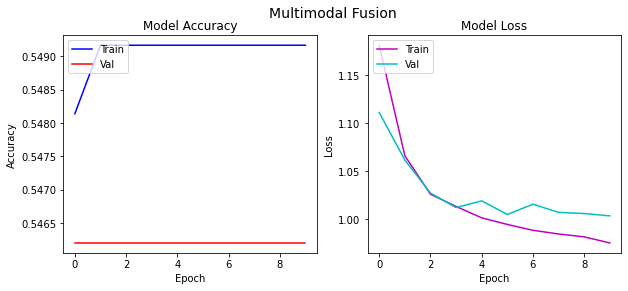

In [11]:
# graph for Early Fusion
plot16.plot_hist(history, 'Multimodal Fusion')

In [47]:
def print_classification_report(model, X_test, y_test):
    # Generate the predicted labels
    y_pred = model.predict(X_test)

    # Convert the predicted probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
 

    # Generate the classification report
    report = classification_report(y_true_labels, y_pred_labels, digits=4)
    print(report)
